In [1]:
!pip install sagemaker.utils


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=613227811e19ce4c0ea8f3d2e12dcbe4d828d949acac28d4cf3129ca66fb121c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc
Successfully built termcolor


In [2]:

!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:

import sagemaker
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

In [2]:

!unzip archive.zip

Archive:  archive.zip
  inflating: Testing/glioma/Te-glTr_0000.jpg  
  inflating: Testing/glioma/Te-glTr_0001.jpg  
  inflating: Testing/glioma/Te-glTr_0002.jpg  
  inflating: Testing/glioma/Te-glTr_0003.jpg  
  inflating: Testing/glioma/Te-glTr_0004.jpg  
  inflating: Testing/glioma/Te-glTr_0005.jpg  
  inflating: Testing/glioma/Te-glTr_0006.jpg  
  inflating: Testing/glioma/Te-glTr_0007.jpg  
  inflating: Testing/glioma/Te-glTr_0008.jpg  
  inflating: Testing/glioma/Te-glTr_0009.jpg  
  inflating: Testing/glioma/Te-gl_0010.jpg  
  inflating: Testing/glioma/Te-gl_0011.jpg  
  inflating: Testing/glioma/Te-gl_0012.jpg  
  inflating: Testing/glioma/Te-gl_0013.jpg  
  inflating: Testing/glioma/Te-gl_0014.jpg  
  inflating: Testing/glioma/Te-gl_0015.jpg  
  inflating: Testing/glioma/Te-gl_0016.jpg  
  inflating: Testing/glioma/Te-gl_0017.jpg  
  inflating: Testing/glioma/Te-gl_0018.jpg  
  inflating: Testing/glioma/Te-gl_0019.jpg  
  inflating: Testing/glioma/Te-gl_0020.jpg  
  inflating: 

## Hyperparameter Tuning


In [9]:
bucket_name = "hany-aws-ml"
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

inputs = sagemaker_session.upload_data(path="./brain/", bucket=bucket_name, key_prefix="data")
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://hany-aws-ml/data


In [10]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]


In [20]:
#TODO: Create estimators for your HPs

# instance_type="ml.m5.large"
# instance_type="ml.m5.2xlarge"
instance_type="ml.p2.xlarge"
# instance_type="ml.g4dn.xlarge"
# instance_type="ml.g4dn.xlarge"
# instance_type="ml.t3.medium"

estimator = PyTorch(
    entry_point="hpo_capstone.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type=instance_type
)




# TODO: Your estimator here

# tuner = HyperparameterTuner(
#     estimator,
#     objective_metric_name,
#     hyperparameter_ranges,
#     metric_definitions,
#     max_jobs=9,
#     max_parallel_jobs=3,
#     objective_type=objective_type,
# )


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)




In [21]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs},wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [22]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-10-29 17:41:23 Starting - Found matching resource for reuse
2022-10-29 17:41:23 Downloading - Downloading input data
2022-10-29 17:41:23 Training - Training image download completed. Training in progress.
2022-10-29 17:41:23 Uploading - Uploading generated training model
2022-10-29 17:41:23 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'lr': '0.0142154184555958',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-10-29-16-54-58-309"',
 'sagemaker_program': '"hpo_capstone.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-721699678207/pytorch-training-2022-10-29-16-54-58-309/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging


In [23]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
#     Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [27]:
# TODO: Create and fit an estimator

best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr']}


estimator = PyTorch(
    entry_point="train_model_capstone.py",
    instance_count=1,
    instance_type="ml.p2.xlarge",
    role=role,
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2022-10-29 18:04:15 Starting - Starting the training job...
2022-10-29 18:04:42 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
ProfilerReport: InProgress
............
2022-10-29 18:06:43 Downloading - Downloading input data...............
2022-10-29 18:09:04 Training - Downloading the training image.........
2022-10-29 18:10:44 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-29 18:10:44,186 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-29 18:10:44,222 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-29 18:10:44,239 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-29 18:10:44,768 sagemaker-training-toolkit INFO     Invoking user script
Train

In [28]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-10-29 18:55:13.584 ip-172-16-141-114.ec2.internal:8198 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-29 18:55:14.010 ip-172-16-141-114.ec2.internal:8198 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-721699678207/pytorch-training-2022-10-29-18-04-14-887/debug-output


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-10-29 18:55:14.529 ip-172-16-141-114.ec2.internal:8198 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-721699678207/pytorch-training-2022-10-29-18-04-14-887/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [29]:
trial.tensor_names()

[2022-10-29 18:55:21.726 ip-172-16-141-114.ec2.internal:8198 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-29 18:55:22.749 ip-172-16-141-114.ec2.internal:8198 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight']

In [30]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    
    plt.show()
    plt.savefig('debugging-output.png')

Matplotlib is building the font cache; this may take a moment.


loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


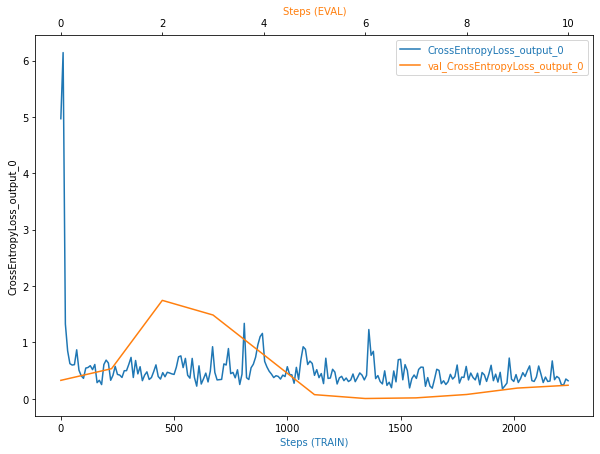

<Figure size 432x288 with 0 Axes>

In [32]:
# TODO: Plot a debugging output.
plot_tensor(trial, "CrossEntropyLoss_output_0")